In [1]:
try:
    import yfinance as yf
except ImportError:
    %pip install yfinance
    import yfinance as yf

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/58/f7/a966b800b49cb5379e348bf0717df481051714a99ece15289718562f6952/yfinance-0.2.35-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.0 MB/s eta 0:00:0000:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 6.0 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.0-cp310-cp310-linux_x86_64.whl size=272555 sha256=cbbcb148dec5fc45fe926ce4de7c680d4e7302a5982ea78fab1ce6ac39a26371
  Stored in directory: /root/.cache/pip/wheels/c7/70/ad/212867e96e7004265a69c4aa5dcff00a95f547a67ba26e7e76
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


# Environment Preparation

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import timeit
import time
from functools import wraps

from keras.models import Sequential
from keras.layers import (Attention, Conv1D, Conv2D, Dense, Dropout, Flatten, GRU,
                         Input, Layer, LSTM, Masking, MaxPooling1D, MaxPooling2D,
                         Multiply, Permute, RepeatVector, Reshape, TimeDistributed)
from keras.optimizers import Adam
from keras.metrics import MeanAbsolutePercentageError, RootMeanSquaredError

from keras import backend as K

from statsmodels.tsa.vector_ar.var_model import VAR

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def watch(function):
    '''Decorator to time the execution of a function
    It returns the original return value and the time elapsed in seconds'''
    @wraps(function)
    def watch_(*args, **kwargs):
        try:
            start = time.time()
        except:
            import time
            start = time.time()
        ret = function(*args, **kwargs)
        end = time.time()
        elapsed = end - start
        print(f'time: {elapsed}')
        return ret, elapsed
    return watch_

In [5]:
ticker_symbol = "^FTSE"
# January 1st, 2013 to october 1st, 2023
start_date = "2013-01-01"
end_date = "2023-10-01"

In [6]:
# Download data
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Load csv
#data = pd.read_csv(r"data.csv")

data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,5897.799805,6044.600098,5897.799805,6027.399902,6027.399902,652659400
2013-01-03,6027.399902,6051.299805,6016.799805,6047.299805,6047.299805,470665900
2013-01-04,6047.299805,6089.799805,6038.000000,6089.799805,6089.799805,548929200
2013-01-07,6089.799805,6091.500000,6060.799805,6064.600098,6064.600098,571661700
2013-01-08,6064.600098,6088.200195,6053.600098,6053.600098,6053.600098,663115700


In [6]:
#data.to_csv("data.csv")

In [ ]:
# Correlation Heatmap
sns.heatmap(data.corr(), cmap='crest', annot=True, fmt='.1f', linewidth=.5)

# Data Preparation

## Technical Indicators (TI)

**Trend Indicators:**
- Simple Moving Average (SMA)
- Exponential Moving Average (EMA) - check [MACD](https://www.investopedia.com/terms/m/macd.asp)

**Momentum Indicators:**
- Relative Strength Index (RSI)
- Awesome Oscillator
- Price rate-of-change (ROC)
- William's %R oscillator
- Stochastic %K
- Stochastic %D

**Volatility Indicators:**
- Average True Range (ATR)
- Average Directional Movement Index (ADX)
- Commodity Channel Index (CCI)

**Volume Indicators**
- On-Balance Volume (OBV)

In [7]:
window_size = 14

# typical price
data['TP'] = (data['Close'] + data['Low'] + data['High'])/3

In [8]:
# Calculate 14-day moving average
data['MA'] = data['Close'].rolling(window=window_size).mean()

In [9]:
# Calculate 14-day exponential moving average
data['EMA'] = data['Close'].ewm(span=window_size).mean()

In [10]:
# Rolling standard deviation, 14 days window
data['STD'] = data['TP'].rolling(window_size).std(ddof=0)

In [11]:
# Relative Strength Index
def rsi(close, periods = 10, ema = True):
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [12]:
data['RSI'] = rsi(data.Close, periods=window_size, ema=True)

In [13]:
# Rate of Change

def roc(close, n):
    N = close.diff(n)
    D = close.shift(n)
    roc = pd.Series(N/D, name='Rate of Change')
    return roc

In [14]:
data['ROC'] = roc(data.Close, window_size)

In [15]:
# Average True Range, 14 days window

def atr(high, low, close):
    high_low = high - low
    high_close = np.abs(high - close.shift())
    low_close = np.abs(low - close.shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    return true_range.rolling(window_size).mean() # or ewm: true_range.ewm(alpha=1/14, adjust=False).mean()


In [16]:
data['ATR'] = atr(data.High, data.Low, data.Close)

In [17]:
# CCI -> ccommunity channel index

def cci(ma, tp, ndays):
    #MAD = tp.rolling(ndays).apply(lambda x: pd.Series(x).mad())
    # mad -> mean absolute deviation
    # replacement for deprecated 'mad' method
    MAD = tp.rolling(ndays).apply(lambda x: (pd.Series(x) - pd.Series(x).mean()).abs().mean())

    cci = (tp - ma) / (0.015 * MAD)
    return cci

In [18]:
data['CCI'] = cci(data.MA, data.TP, window_size)


In [19]:
# stochastic K and D

k_period = 14
d_period = 3

# "n_high" column with max value of previous 14 periods
n_high = data['High'].rolling(k_period).max()
# "n_low" column with min value of previous 14 periods
n_low = data['Low'].rolling(k_period).min()

# Uses the min/max values to calculate the %k (as a percentage)
data['%K'] = (data['Close'] - n_low) * 100 / (n_high - n_low)

# Uses the %k to calculates a SMA over the past 3 values of %k
data['%D'] = data['%K'].rolling(d_period).mean()

In [20]:
# average directional movement index

def get_adx(high, low, close, atr, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()

    # return adx_smooth
    return plus_di, minus_di, adx_smooth

In [21]:
data['plus_di'], data['minus_di'], data['ADMI'] = get_adx(data['High'], data['Low'], data['Close'], data['ATR'], lookback=14)

In [22]:
# Awesome  Oscillator
def AO(close):
    sma5 = close.rolling(5).mean()
    sma34 = close.rolling(34).mean()
    ao = sma5 - sma34
    return ao

In [23]:
data['AO'] = AO(data.Close)

In [24]:
# William's R oscillator

def wil_r(high, low, close, lookback):
    highh = high.rolling(lookback).max()
    lowl = low.rolling(lookback).min()
    wr = -100 * ((highh - close) / (highh - lowl))
    return wr


In [25]:
data['WIL_R'] = wil_r(data.High, data.Low, data.Close, 14)

In [26]:
# On Balance Volume
def obv(close, volume):
    obv_series = [0]  # Initialize OBV with 0
    for i in range(1, len(close)):
        if close[i] > close[i-1]:
            obv_series.append(obv_series[-1] + volume[i])  # If current close price is higher, add volume to OBV
        elif close[i] < close[i-1]:
            obv_series.append(obv_series[-1] - volume[i])  # If current close price is lower, subtract volume from OBV
        else:
            obv_series.append(obv_series[-1])  # If current close price is the same, keep OBV unchanged
    return obv_series

In [28]:
data["OBV"] = obv(data.Close, data.Volume)

/tmp/ipykernel_43/2090444909.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if close[i] > close[i-1]:
/tmp/ipykernel_43/2090444909.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obv_series.append(obv_series[-1] + volume[i])  # If current close price is higher, add volume to OBV
/tmp/ipykernel_43/2090444909.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif close[i] < close[i-1]:
/tmp/ipykernel_43/2090444909.py:8: Fut

In [29]:
data = data.dropna()
data.head()

,Open,High,Low,Close,Adj Close,Volume,TP,MA,EMA,STD,...,ATR,CCI,%K,%D,plus_di,minus_di,ADMI,AO,WIL_R,OBV
Date,,,,,,,,,,,,,,,,,,,,,
2013-02-18,6328.299805,6330.200195,6306.799805,6318.200195,6318.200195,459974900,6318.400065,6300.921387,6297.128076,30.090837,...,60.750070,43.081213,60.416667,64.245896,23.972042,10.658673,45.430463,123.274121,-39.583333,6635581400
2013-02-19,6318.200195,6385.100098,6304.399902,6379.100098,6379.100098,672871900,6356.200033,6304.921387,6308.131188,32.436515,...,63.785784,118.592607,96.437053,74.427353,27.743536,9.655102,44.862179,121.070037,-3.562947,7308453300
2013-02-20,6379.100098,6412.399902,6368.200195,6395.399902,6395.399902,756333900,6392.000000,6313.385672,6319.834780,39.410935,...,63.642892,157.180413,91.313222,82.722314,28.970705,8.929751,45.202081,118.091760,-8.686778,8064787200
2013-02-21,6395.399902,6395.399902,6278.000000,6291.500000,6291.500000,733017000,6321.633301,6309.407087,6316.037756,39.316634,...,66.421456,24.622762,38.221725,75.324000,25.628159,18.322817,45.646128,104.979420,-61.778275,7331770200
2013-02-22,6291.500000,6347.299805,6291.500000,6335.700195,6335.700195,702828200,6324.833333,6315.757115,6318.670866,38.340747,...,62.507185,19.520441,60.807449,63.447465,25.153820,17.983689,43.151696,98.485966,-39.192551,8034598400


## Feature Selection

In [31]:
# Remove highly correlated (duplicate) features
features_to_drop = ['Adj Close', 'Open', 'Low', 'High', 'TP']
data = data.drop(features_to_drop, axis=1)
data.head()

,Close,Volume,MA,EMA,STD,RSI,ROC,ATR,CCI,%K,%D,plus_di,minus_di,ADMI,AO,WIL_R,OBV
Date,,,,,,,,,,,,,,,,,
2013-02-18,6318.200195,459974900,6300.921387,6297.128076,30.090837,59.435707,-0.003313,60.750070,43.081213,60.416667,64.245896,23.972042,10.658673,45.430463,123.274121,-39.583333,6635581400
2013-02-19,6379.100098,672871900,6304.921387,6308.131188,32.436515,65.242126,0.008856,63.785784,118.592607,96.437053,74.427353,27.743536,9.655102,44.862179,121.070037,-3.562947,7308453300
2013-02-20,6395.399902,756333900,6313.385672,6319.834780,39.410935,66.619365,0.018879,63.642892,157.180413,91.313222,82.722314,28.970705,8.929751,45.202081,118.091760,-8.686778,8064787200
2013-02-21,6291.500000,733017000,6309.407087,6316.037756,39.316634,52.373591,-0.008776,66.421456,24.622762,38.221725,75.324000,25.628159,18.322817,45.646128,104.979420,-61.778275,7331770200
2013-02-22,6335.700195,702828200,6315.757115,6318.670866,38.340747,56.623091,0.014231,62.507185,19.520441,60.807449,63.447465,25.153820,17.983689,43.151696,98.485966,-39.192551,8034598400


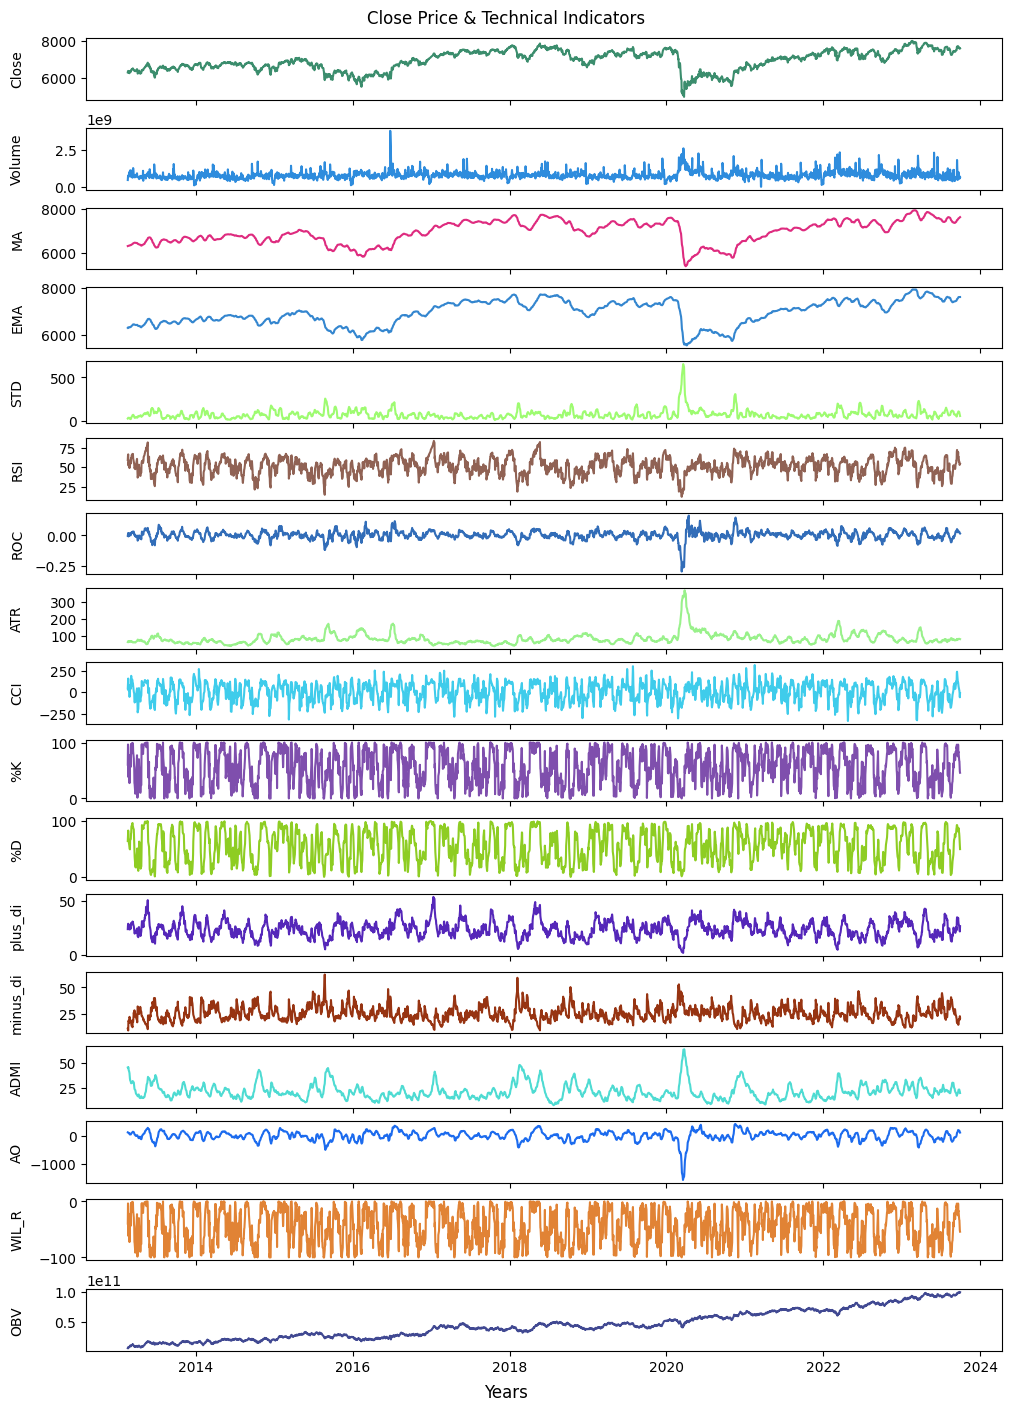

In [32]:
# Plot Technical Indicators
fig, axes = plt.subplots(nrows=17, ncols=1, sharex=True, constrained_layout=True, figsize=(10,14))

for axis,column in zip(axes, data.columns):
    c = np.random.rand(1,3) # 1x3 array of random numbers betwen 0 and 1
    axis.plot(data[column], color=c)# plot series with random colors
    axis.set_ylabel(data[column].name) # set title of plot to name of column

fig.supxlabel('Years') # add Label to the x-axis
fig.suptitle('Close Price & Technical Indicators') # add title to the plot
fig.align_ylabels(axes) # align ylabels of the axes

plt.show()

## Data Reshaping

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Close', ylabel='Density'>

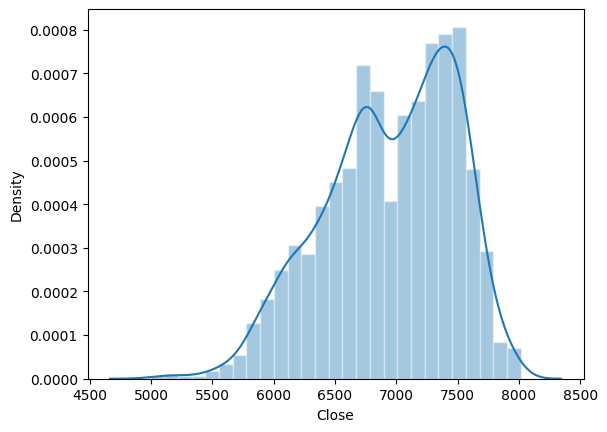

In [33]:
#sns.displot(data['Close'], kind='kde', rug=True)
sns.histplot(
    data['Close'], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Volume', ylabel='Density'>

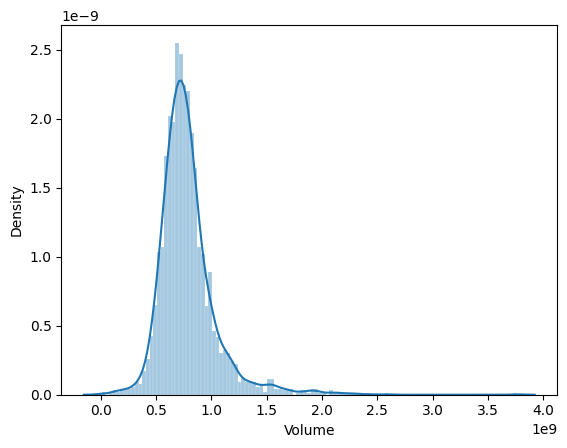

In [34]:
sns.histplot(
    data['Volume'], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
)

In [35]:
# both volume and close price are skewed
# normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

In [36]:
scaled_data.head()

,Close,Volume,MA,EMA,STD,RSI,ROC,ATR,CCI,%K,%D,plus_di,minus_di,ADMI,AO,WIL_R,OBV
0,0.438452,0.120332,0.361178,0.311864,0.025924,0.658382,0.639629,0.074900,0.582621,0.604167,0.642453,0.424079,0.032429,0.673314,0.850708,0.604167,0.000000
1,0.458615,0.177060,0.362727,0.316494,0.029599,0.739095,0.666536,0.084003,0.699219,0.964371,0.745229,0.496521,0.013605,0.663129,0.849597,0.964371,0.007194
2,0.464011,0.199300,0.366007,0.321419,0.040526,0.758239,0.688695,0.083574,0.758802,0.913132,0.828961,0.520092,0.000000,0.669221,0.848095,0.913132,0.015281
3,0.429612,0.193087,0.364465,0.319821,0.040378,0.560214,0.627551,0.091906,0.554119,0.382217,0.754280,0.455889,0.176182,0.677179,0.841482,0.382217,0.007444
4,0.444246,0.185042,0.366926,0.320929,0.038849,0.619285,0.678420,0.080169,0.546241,0.608074,0.634393,0.446778,0.169821,0.632472,0.838207,0.608074,0.014958


In [37]:
def lag_data(data:pd.DataFrame, seq_length=10, lookahead=1) -> np.ndarray: 
    '''uses data from {seq_length} number of days to predict {lookahead} days of close price'''
    X_data, y_data = [],[]

    for i in range(len(data) - lookahead - seq_length + 1):
        # get a portion of the dataframe for seq_length days
        seq = data.loc[i : i+seq_length-1]

        # get the close price for lookahead days
        y = data.Close.loc[i+seq_length: i+seq_length+lookahead-1]
        
        X_data.append(seq); y_data.append(y)

    X_data = np.array(X_data)
    y_data = np.array(y_data)
    return X_data, y_data

In [38]:
lookahead = 1
seq_length = 10

X_data, y_data = lag_data(scaled_data, lookahead=lookahead, seq_length=seq_length)

In [39]:
X_data.shape

(2671, 10, 17)

In [40]:
train = 0.7
test = 0.2
val = (1 - (train + test))/train

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test, shuffle=False)

# validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val, shuffle=False)

In [41]:
print(f"train shape: {X_train.shape}, {y_train.shape}")
print(f"test shape:, {X_test.shape}, {y_test.shape}")
print(f"val shape:, {X_val.shape}, {y_val.shape}")

train shape: (1830, 10, 17), (1830, 1)
test shape:, (535, 10, 17), (535, 1)
val shape:, (306, 10, 17), (306, 1)


In [43]:
from datetime import datetime, timedelta

In [44]:
# Define the date
date_october_1_2023 = datetime(2023, 10, 1)

# Calculate 306 days before the given date
date_306_days_before = date_october_1_2023 - timedelta(days=306)

# Print the result
print("Date 306 days before October 1st, 2023:", date_306_days_before.date())

Date 306 days before October 1st, 2023: 2022-11-29


# Model Building

In [45]:
# individually unscale the Close price (target variable)
def unscale(scaled_value):
    # close price is the firt column, hence data_max_[0]
    unscaled_value = scaled_value * (scaler.data_max_[0] - scaler.data_min_[0]) + (scaler.data_min_[0])
    return unscaled_value

Performance metrics
1. MSE
2. MAPE (%)
3. RMSE
4. SMAPE(%)
5. R2(%)
6. MASE
7. RMSSE
8. MDA(%)

In [46]:
# METRICS
def MSE(y_true, y_pred):
    name = 'mean_squared_error'
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

def MAPE(y_true, y_pred):
    name = 'mean_absolute_percentage_error'
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

def RMSE(y_true, y_pred):
    name = 'root_mean_squared_error'
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

def SMAPE(y_true, y_pred):
    name = 'symmetric_mean_absolute_percentage_error'
    diff = np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))
    smape = 2.0 * np.mean(diff, axis=-1)
    
    smape = np.mean(np.abs(np.divide(np.subtract(y_true, y_pred), np.add(np.abs(y_true), np.abs(y_pred))))) * 200
    
    return smape

def R2(y_true, y_pred):
    name = 'coefficient_of_determination'
    SS_res = np.sum(np.square(np.subtract(y_true, y_pred)))
    SS_tot = np.sum(np.square(np.subtract(y_true, np.mean(y_true))))
    r2 =  1 - SS_res / SS_tot
    return r2 * 100

def MASE(y_true, y_pred):
    name = 'mean_absolute_scaled_error'
    naive_error = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    mase = np.mean(np.abs(y_true - y_pred)) / naive_error
    return mase

def RMSSE(y_true, y_pred):
    name = 'root_mean_squared_scaled_error'
    naive_error = np.sqrt(np.mean(np.square(y_true[1:] - y_true[:-1])))
    rmsse = np.sqrt(np.mean(np.square(y_true - y_pred))) / naive_error
    return rmsse

def MDA(y_true, y_pred):
    name = 'mean_directional_accuracy'
    mda = np.mean(np.equal(np.sign(y_true[1:] - y_true[:-1]), np.sign(y_pred[1:] - y_pred[:-1]))) * 100
#     mda = np.mean(np.abs(np.subtract(y_true, y_pred)))
    return mda

In [47]:
metrics = [MSE, MAPE, RMSE, MDA, RMSSE, SMAPE, R2, MASE]
metrics_name = ['MSE', 'MAPE', 'RMSE', 'MDA', 'RMSSE', 'SMAPE', 'R2', 'MASE']

In [48]:
def evaluate(model, metrics:list, X_test, y_test, scaled=False):
    '''Evaluate a model.
    Inputs: modelname, list of metric(s), X_test, y_test'''
    results = {}
    values = []
    for metric_name, metric in zip(metrics_name, metrics):
        #each metric funtion must be written to take y_true, y_pred
        if scaled:
            # based on the assumption that the models are trained using scaled feature values
            # y_test and y_pred will be scaled, however, prediction will still be done using the scaled X_test
            metric_value = metric(y_test, model.predict(X_test))
            values.append(metric_value)
        else:
            try:
                metric_value = metric(unscale(y_test), unscale(model.predict(X_test)))
            except:
                print("Unscale function not defined. Using scaled values as default")
                metric_value = metric(y_test, model.predict(X_test))
        values.append(metric_value)
        results[metric_name] = metric_value
    return results

In [49]:
def printm(metrics: dict):
    for metric in metrics:
        print(metric, ': ', metrics[metric])

In [50]:
# model parameters
selected_features = data.columns
print(selected_features)

Index(['Close', 'Volume', 'MA', 'EMA', 'STD', 'RSI', 'ROC', 'ATR', 'CCI', '%K',
       '%D', 'plus_di', 'minus_di', 'ADMI', 'AO', 'WIL_R', 'OBV'],
      dtype='object')


## CNN-LSTM model

### 2D CNN

In [51]:
cnn2 = Sequential()
cnn2.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(seq_length, len(selected_features), 1)))
cnn2.add(MaxPooling2D(pool_size=2))
cnn2.add(Reshape((14, 64)))

#LSTM layers
cnn2.add(LSTM(64, return_sequences=True))
cnn2.add(Flatten())
cnn2.add(Dense(32, activation='relu'))

#Final dense prediction layer
cnn2.add(Dense(lookahead))

In [52]:
# Compile the model
cnn2.compile(optimizer = Adam(learning_rate=0.001),
    loss='mse', metrics = [MeanAbsolutePercentageError(), RootMeanSquaredError()])
cnn2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 15, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 7, 32)          0         
 D)                                                              
                                                                 
 reshape (Reshape)           (None, 14, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 14, 64)            33024     
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense (Dense)               (None, 32)                28704     
                                                        

In [48]:
history_cnn2, time_cnn2 = watch(cnn2.fit)(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/60
58/58 [==============================] - 7s 19ms/step - loss: 0.0438 - mean_absolute_percentage_error: 269124.7812 - root_mean_squared_error: 0.2093 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 22.7854 - val_root_mean_squared_error: 0.1085
Epoch 2/60
58/58 [==============================] - 0s 6ms/step - loss: 0.0107 - mean_absolute_percentage_error: 290184.8750 - root_mean_squared_error: 0.1033 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 19.9119 - val_root_mean_squared_error: 0.0945
Epoch 3/60
58/58 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 255711.4531 - root_mean_squared_error: 0.0749 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 9.3801 - val_root_mean_squared_error: 0.0499
Epoch 4/60
58/58 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_absolute_percentage_error: 201619.4062 - root_mean_squared_error: 0.0601 - val_loss: 0.0019 - val_mean_absolute_percentage_error

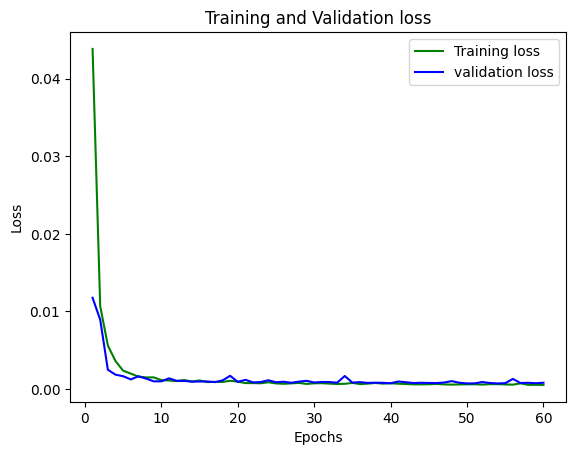

In [49]:
# plot loss against epoch
loss_train = history_cnn2.history['loss']
loss_val = history_cnn2.history['val_loss']

epochs = range(1,61)

plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
# Evaluate the model
evaluate(cnn2, metrics, X_test, y_test, scaled=False)

17/17 [==============================] - 0s 2ms/step


{'MSE': 7334.714694825738,
 'MAPE': 0.9096691568059024,
 'RMSE': 85.64294889146296,
 'MDA': 46.254681647940075,
 'RMSSE': 1.3041388772358504,
 'SMAPE': 0.9126939670022464,
 'R2': 88.61115688691719,
 'MASE': 1.4487720520296474}

In [51]:
print(time_cnn2)

28.138558626174927


In [52]:
prediction_cnn2 = cnn2.predict(X_test)

17/17 [==============================] - 0s 2ms/step


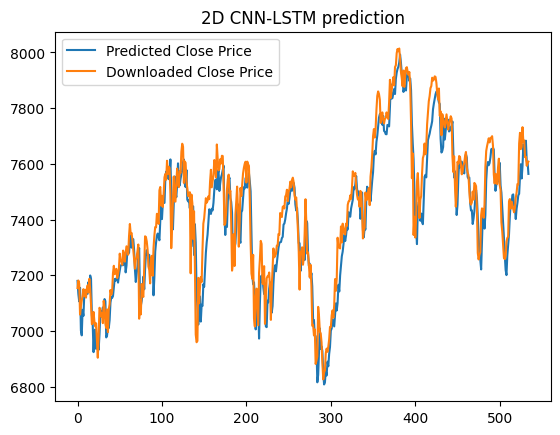

In [53]:
plt.plot(unscale(prediction_cnn2), label="Predicted Close Price")
plt.plot(unscale(y_test), label="Downloaded Close Price")
plt.title("2D CNN-LSTM prediction")
plt.legend()
plt.show()

### 1D CNN

In [ ]:
# Define the model
cnn1 = Sequential()

# CNN layers
cnn1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, len(selected_features))))
cnn1.add(MaxPooling1D(pool_size=2))
cnn1.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn1.add(MaxPooling1D(pool_size=2))

# LSTM layer
cnn1.add(LSTM(64, return_sequences=True))
cnn1.add(Flatten())
cnn1.add(Dense(32, activation='relu'))

# Add a dense layer for final prediction
cnn1.add(Dense(lookahead))

In [ ]:
# Compile the model
cnn1.compile(
    optimizer = Adam(learning_rate=0.001),
    loss='mse', metrics = [
        MeanAbsolutePercentageError(), RootMeanSquaredError()]
)
cnn1.summary()

In [56]:
# Train the model
history_cnn1, time_cnn1 = watch(cnn1.fit)(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
58/58 [==============================] - 5s 18ms/step - loss: 0.0571 - mean_absolute_percentage_error: 232654.9688 - root_mean_squared_error: 0.2389 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 23.6713 - val_root_mean_squared_error: 0.1101
Epoch 2/50
58/58 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_absolute_percentage_error: 60800.1836 - root_mean_squared_error: 0.0568 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 11.7123 - val_root_mean_squared_error: 0.0579
Epoch 3/50
58/58 [==============================] - 0s 6ms/step - loss: 0.0019 - mean_absolute_percentage_error: 82368.3594 - root_mean_squared_error: 0.0431 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 9.7112 - val_root_mean_squared_error: 0.0496
Epoch 4/50
58/58 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_absolute_percentage_error: 75418.2031 - root_mean_squared_error: 0.0390 - val_loss: 0.0022 - val_mean_absolute_percentage_error: 9

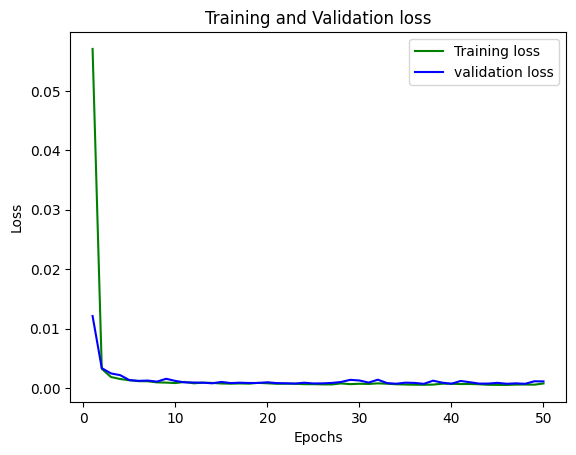

In [57]:
# plot loss against epoch
loss_train = history_cnn1.history['loss']
loss_val = history_cnn1.history['val_loss']

epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend()
plt.show()

In [58]:
# Evaluate the model
evaluate(cnn1, metrics, X_test, y_test, scaled=False)

17/17 [==============================] - 0s 2ms/step


{'MSE': 11282.452699855108,
 'MAPE': 1.0387659982199364,
 'RMSE': 106.21889050378519,
 'MDA': 49.812734082397,
 'RMSSE': 1.6174616404019277,
 'SMAPE': 1.03674962047026,
 'R2': 82.48137942978569,
 'MASE': 1.6406394824546071}

In [59]:
print(time_cnn1)

22.384603023529053


In [60]:
# Make predictions
prediction_cnn1 = cnn1.predict(X_test)

17/17 [==============================] - 0s 2ms/step


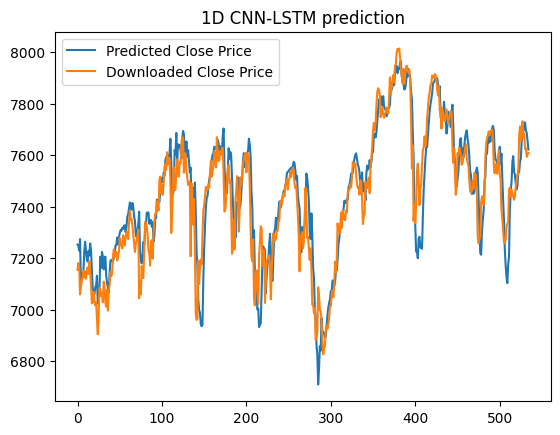

In [61]:
plt.plot(unscale(prediction_cnn1), label="Predicted Close Price")
plt.plot(unscale(y_test), label="Downloaded Close Price")
plt.title("1D CNN-LSTM prediction")
plt.legend()
plt.show()

## GRU with Attention Mechanism

### GRU

In [187]:
gru_model = Sequential()
gru_model.add(GRU(32, return_sequences=True, input_shape=(seq_length, len(selected_features))))
gru_model.add(Dropout(0.3))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(128))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(lookahead, activation='sigmoid'))

In [188]:
gru_model.compile(optimizer='adam', loss='mse', metrics = [
        MeanAbsolutePercentageError(), RootMeanSquaredError()])
gru_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_36 (GRU)                (None, 10, 32)            4896      
                                                                 
 dropout_36 (Dropout)        (None, 10, 32)            0         
                                                                 
 gru_37 (GRU)                (None, 10, 64)            18816     
                                                                 
 dropout_37 (Dropout)        (None, 10, 64)            0         
                                                                 
 gru_38 (GRU)                (None, 128)               74496     
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 1)               

In [189]:
history_gru, time_gru = watch(gru_model.fit)(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
58/58 [==============================] - 7s 25ms/step - loss: 0.0103 - mean_absolute_percentage_error: 100238.6328 - root_mean_squared_error: 0.1014 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 15.7851 - val_root_mean_squared_error: 0.0753
Epoch 2/100
58/58 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_absolute_percentage_error: 117149.9609 - root_mean_squared_error: 0.0535 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 14.5428 - val_root_mean_squared_error: 0.0719
Epoch 3/100
58/58 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_absolute_percentage_error: 92115.3516 - root_mean_squared_error: 0.0486 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 11.7194 - val_root_mean_squared_error: 0.0610
Epoch 4/100
58/58 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_absolute_percentage_error: 118989.0078 - root_mean_squared_error: 0.0472 - val_loss: 0.0024 - val_mean_absolute_percentage_e

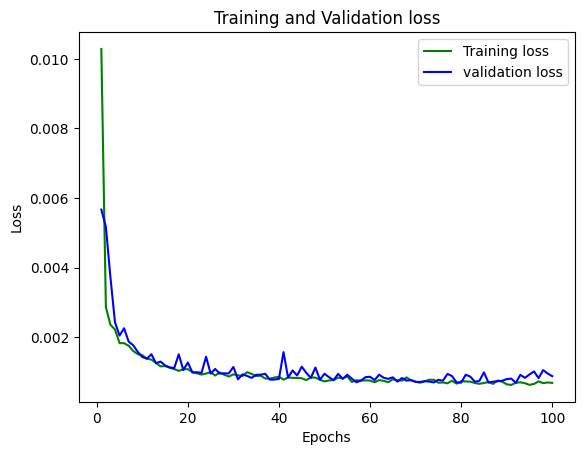

In [190]:
# plot loss against epoch
loss_train = history_gru.history['loss']
loss_val = history_gru.history['val_loss']

epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend()
plt.show()

In [191]:
# Evaluate the model
evaluate(gru_model, metrics, X_test, y_test, scaled=False)

17/17 [==============================] - 0s 3ms/step


{'MSE': 11708.415215304194,
 'MAPE': 1.187281389376661,
 'RMSE': 108.20543061835757,
 'MDA': 48.87640449438202,
 'RMSSE': 1.6477119322021982,
 'SMAPE': 1.1962842707676615,
 'R2': 81.8199739815375,
 'MASE': 1.907806089992519}

In [192]:
print(time_gru)

54.295090675354004


In [193]:
# Make predictions
prediction_gru = gru_model.predict(X_test)

17/17 [==============================] - 0s 3ms/step


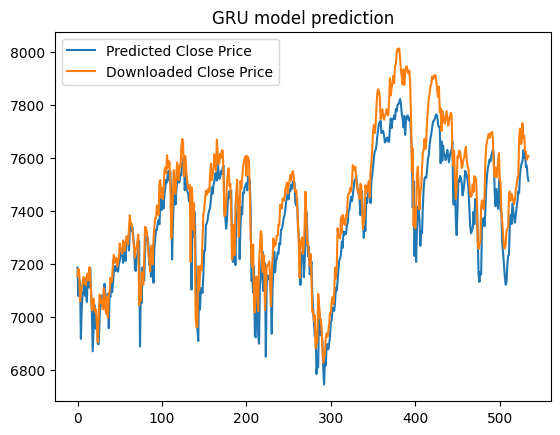

In [194]:
plt.plot(unscale(prediction_gru), label="Predicted Close Price")
plt.plot(unscale(y_test), label="Downloaded Close Price")
plt.title("GRU model prediction")
plt.legend()
plt.show()

### GRU with attention mechanism

In [146]:
# Attention Layer class
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        self.attention_weights = None

    def __call__(self, x):
        self.attention_weights = K.exp(x - K.max(x, axis=1, keepdims=True))
        return self.attention_weights / K.sum(self.attention_weights, axis=1, keepdims=True)

    def get_output_shape(self, input_shape):
        return input_shape

In [147]:
class AttentionLayer(Layer):
    def __init__(self,**kwargs):
        super(AttentionLayer,self).__init__(**kwargs)
        
    def build(self,input_shape):
        self.w=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal", trainable=True)
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros", trainable=True)
        super(AttentionLayer,self).build(input_shape)
        
    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.w)+self.b), axis=-1)
        at=K.softmax(et, axis=-1)
        at=K.expand_dims(at) #axis=-1
        output=x*at
        return K.sum(output,axis=1)
    
    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(AttentionLayer,self).get_config()      

In [170]:
gru_att_model = Sequential()
gru_att_model.add(GRU(32, return_sequences=True, input_shape=(seq_length, len(selected_features))))
gru_att_model.add(Dropout(0.3))
gru_att_model.add(GRU(64, return_sequences=True))
gru_att_model.add(Dropout(0.2))
gru_att_model.add(GRU(128, return_sequences=True))
gru_att_model.add(Dropout(0.2))
gru_att_model.add(AttentionLayer())
gru_att_model.add(Flatten())
gru_att_model.add(Dense(lookahead, activation='sigmoid'))

gru_att_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_30 (GRU)                (None, 10, 64)            15936     
                                                                 
 dropout_30 (Dropout)        (None, 10, 64)            0         
                                                                 
 gru_31 (GRU)                (None, 10, 64)            24960     
                                                                 
 dropout_31 (Dropout)        (None, 10, 64)            0         
                                                                 
 gru_32 (GRU)                (None, 10, 96)            46656     
                                                                 
 dropout_32 (Dropout)        (None, 10, 96)            0         
                                                                 
 attention_layer_8 (Attenti  (None, 96)              

In [171]:
gru_att_model.compile(
    optimizer='adam',
    loss='mse', metrics = [
        MeanAbsolutePercentageError(), RootMeanSquaredError()]
                     )
history_att, time_att = watch(gru_att_model.fit)(X_train, y_train, epochs=120, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/120
58/58 [==============================] - 7s 28ms/step - loss: 0.0115 - mean_absolute_percentage_error: 304737.2812 - root_mean_squared_error: 0.1071 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 14.5824 - val_root_mean_squared_error: 0.0717
Epoch 2/120
58/58 [==============================] - 1s 9ms/step - loss: 0.0035 - mean_absolute_percentage_error: 174614.9219 - root_mean_squared_error: 0.0595 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 12.1137 - val_root_mean_squared_error: 0.0608
Epoch 3/120
58/58 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_absolute_percentage_error: 124174.8828 - root_mean_squared_error: 0.0542 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 11.9041 - val_root_mean_squared_error: 0.0592
Epoch 4/120
58/58 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_absolute_percentage_error: 109542.9453 - root_mean_squared_error: 0.0533 - val_loss: 0.0042 - val_mean_absolute_percentage_

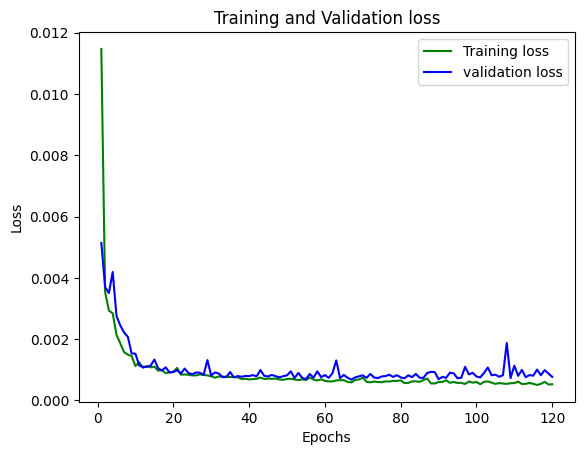

In [172]:
# plot loss against epoch
loss_train = history_att.history['loss']
loss_val = history_att.history['val_loss']

epochs = range(1,121)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend()
plt.show()

In [173]:
gru_att_predictions = gru_att_model.predict(X_test)

17/17 [==============================] - 1s 4ms/step


In [174]:
# Evaluate the model
evaluate(gru_att_model, metrics, X_test, y_test, scaled=False)

17/17 [==============================] - 0s 3ms/step


{'MSE': 11150.263974087267,
 'MAPE': 1.1377465744001956,
 'RMSE': 105.59481035584687,
 'MDA': 51.31086142322098,
 'RMSSE': 1.6079583807177136,
 'SMAPE': 1.1461010093726616,
 'R2': 82.6866330383753,
 'MASE': 1.8303134615991519}

In [175]:
print(time_att)

68.0907142162323


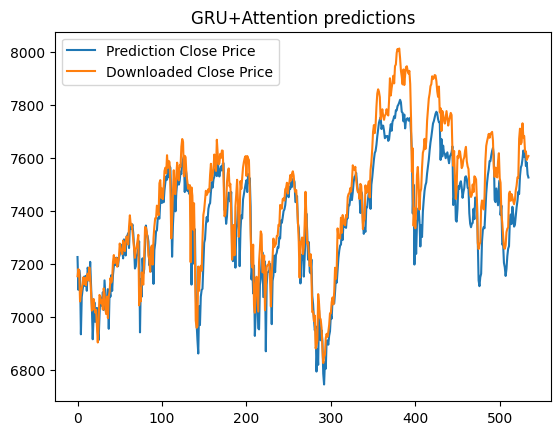

In [176]:
plt.plot(unscale(gru_att_predictions), label="Prediction Close Price")
plt.plot(unscale(y_test), label="Downloaded Close Price")
plt.title("GRU+Attention predictions")
plt.legend()
plt.show()

Baseline GRU without TIs

In [177]:
# call create_sequences on them both
gb_scaled_data = scaled_data[["Close", "Volume"]]
gb_X_data, gb_y_data = lag_data(gb_scaled_data, lookahead=lookahead, seq_length=seq_length)

In [178]:
# train test split
gb_X_train, gb_X_test, gb_y_train, gb_y_test = train_test_split(gb_X_data, gb_y_data, test_size=test, shuffle=False)

# validation data
gb_X_train, gb_X_val, gb_y_train, gb_y_val = train_test_split(gb_X_train, gb_y_train, test_size=val, shuffle=False)

In [179]:
gru_base = Sequential()
gru_base.add(GRU(32, return_sequences=True, input_shape=(seq_length, 2)))
gru_base.add(Dropout(0.3))
gru_base.add(GRU(64, return_sequences=True))
gru_base.add(Dropout(0.2))
gru_base.add(GRU(128))
gru_base.add(Dropout(0.2))
gru_base.add(Dense(lookahead, activation='sigmoid'))

In [180]:
gru_base.compile(optimizer='adam', loss='mse', metrics = [
        MeanAbsolutePercentageError(), RootMeanSquaredError()])
gru_base.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_33 (GRU)                (None, 10, 16)            960       
                                                                 
 dropout_33 (Dropout)        (None, 10, 16)            0         
                                                                 
 gru_34 (GRU)                (None, 10, 16)            1632      
                                                                 
 dropout_34 (Dropout)        (None, 10, 16)            0         
                                                                 
 gru_35 (GRU)                (None, 16)                1632      
                                                                 
 dropout_35 (Dropout)        (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 1)               

In [181]:
history_gru_base, gru_base_time = watch(gru_base.fit)(gb_X_train, gb_y_train, epochs=50, batch_size=32, validation_data=(gb_X_val, gb_y_val))

Epoch 1/50
58/58 [==============================] - 7s 26ms/step - loss: 0.0244 - mean_absolute_percentage_error: 283045.9062 - root_mean_squared_error: 0.1563 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 28.4137 - val_root_mean_squared_error: 0.1323
Epoch 2/50
58/58 [==============================] - 0s 8ms/step - loss: 0.0097 - mean_absolute_percentage_error: 180329.3750 - root_mean_squared_error: 0.0985 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 10.1453 - val_root_mean_squared_error: 0.0582
Epoch 3/50
58/58 [==============================] - 0s 8ms/step - loss: 0.0065 - mean_absolute_percentage_error: 68829.9922 - root_mean_squared_error: 0.0808 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 8.9803 - val_root_mean_squared_error: 0.0509
Epoch 4/50
58/58 [==============================] - 0s 8ms/step - loss: 0.0059 - mean_absolute_percentage_error: 91113.3438 - root_mean_squared_error: 0.0767 - val_loss: 0.0024 - val_mean_absolute_percentage_error: 

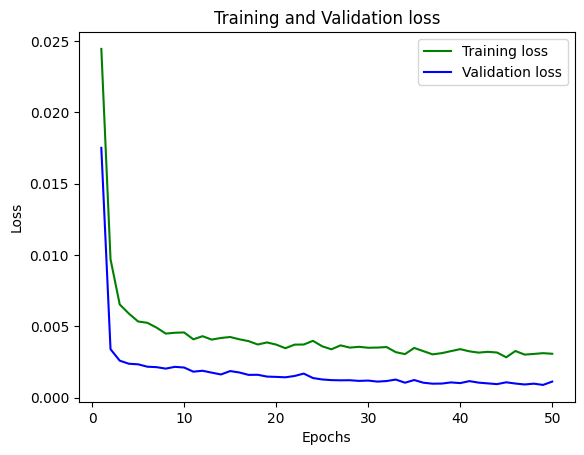

In [182]:
# plot loss against epoch
loss_train = history_gru_base.history['loss']
val_loss = history_gru_base.history['val_loss']

epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend()
plt.show()

In [183]:
# Evaluate the model
evaluate(gru_base, metrics, gb_X_test, gb_y_test, scaled=False)

17/17 [==============================] - 0s 3ms/step


{'MSE': 14376.066440768114,
 'MAPE': 1.3104718664336172,
 'RMSE': 119.90023536577446,
 'MDA': 50.749063670411985,
 'RMSSE': 1.8257960562334419,
 'SMAPE': 1.3202962105585687,
 'R2': 77.67782768801305,
 'MASE': 2.118852905371467}

In [184]:
print(gru_base_time)

29.880889892578125


In [185]:
prediction_gru_base = gru_base.predict(gb_X_test)

17/17 [==============================] - 0s 3ms/step


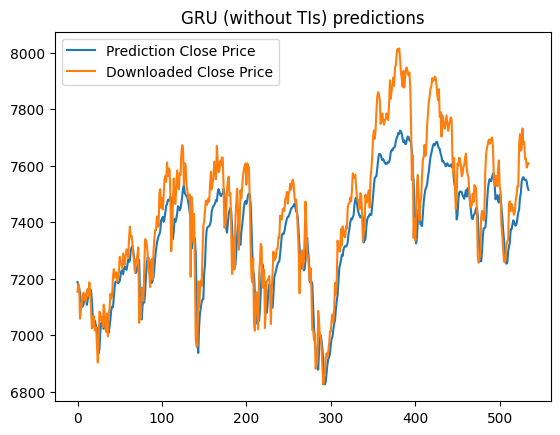

In [186]:
plt.plot(unscale(prediction_gru_base), label="Prediction Close Price")
plt.plot(unscale(gb_y_test), label="Downloaded Close Price")
plt.title("GRU (without TIs) predictions")
plt.legend()
plt.show()

VAR

In [89]:
!pip install --upgrade statsmodels

  Obtaining dependency information for statsmodels from https://files.pythonhosted.org/packages/39/88/d8cd64c8c56131a796215ce7f80ebb73e97200e6e6de26580cd20ae56e3e/statsmodels-0.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for patsy>=0.5.4 from https://files.pythonhosted.org/packages/43/f3/1d311a09c34f14f5973bb0bb0dc3a6e007e1eda90b5492d082689936ca51/patsy-0.5.6-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 44.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 5.0 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.3
    Uninstalling patsy-0.5.3:
      Successfully uninstalled patsy-0.5.3
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.0
    Uninstalling statsmodels-0.14.0:
      Successfully uninstalled statsmodels-0.14.0
ERROR: pip's dependency resolver does not 

In [90]:
# VAR data
var_train, var_test = scaled_data[:-535], scaled_data[-535:]
var_train_close, var_test_close = scaled_data.Close[:-535], scaled_data.Close[-535:]

In [91]:
train_features = var_train[["Close","Volume"]].values
test_features = var_test[["Close","Volume"]].values

test_data_var = train_features[-seq_length:]

In [92]:
var_train.columns

Index(['Close', 'Volume', 'MA', 'EMA', 'STD', 'RSI', 'ROC', 'ATR', 'CCI', '%K',
       '%D', 'plus_di', 'minus_di', 'ADMI', 'AO', 'WIL_R', 'OBV'],
      dtype='object')

In [93]:
var_model= VAR(train_features)
var_model_fit = var_model.fit(4) #trend='ct' ic='aic', maxlags=2

# Display the VAR model summary
print(var_model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Jan, 2024
Time:                     22:12:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.4688
Nobs:                     2142.00    HQIC:                  -13.4990
Log likelihood:           8415.42    FPE:                1.34855e-06
AIC:                     -13.5165    Det(Omega_mle):     1.33729e-06
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.001747         0.002863            0.610           0.542
L1.y1         0.993618         0.021899           45.373           0.000
L1.y2        -0.013909         0.008484           -1.639           0.101
L2.y1         0.002999

In [94]:
# Make predictions for the test set
forecast = []
for _ in range(len(test_features)):
    forecast_step = var_model_fit.forecast(test_data_var, steps=1)
    forecast.append(forecast_step[0])
    test_data_var = np.vstack((test_data_var[1:], forecast_step))

In [95]:
# Convert the forecasted results to a DataFrame
forecasted_data = pd.DataFrame(forecast, columns=["Close", "Volume"])

In [96]:
forecasted_data.head()

,Close,Volume
0,0.735470,0.155827
1,0.733605,0.162466
2,0.731773,0.167591
3,0.730283,0.171139
4,0.728880,0.176338


In [97]:
forecasted_data.shape

(535, 2)

In [98]:
# Evaluate the model
results = {}
values = []
for metric_name, metric in zip(metrics_name, metrics):
    '''#if scaled:
            # based on the assumption that the models are trained using scaled feature values
            # y_test and y_pred will be scaled, however, prediction will still be done using the scaled X_test
            metric_value = metric(y_test, model.predict(X_test))
            values.append(metric_value)'''
    metric_value = metric(unscale(var_test_close.values), unscale(forecasted_data.Close.values))
    values.append(metric_value)
    results[metric_name] = metric_value

In [99]:
printm(results)

MSE :  318720.2599266173
MAPE :  6.461289677215727
RMSE :  564.5531506657431
MDA :  45.69288389513109
RMSSE :  8.596804775863752
SMAPE :  6.746414502608762
R2 :  -394.8870117369247
MASE :  10.499377007176784


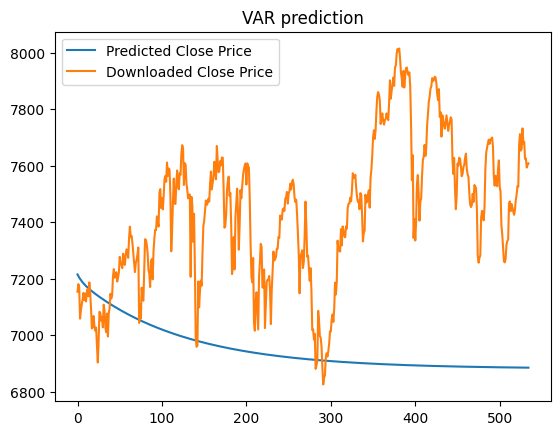

In [100]:
plt.plot(unscale(forecasted_data.Close.values), label="Predicted Close Price")
plt.plot(unscale(var_test_close.values), label="Downloaded Close Price")
plt.title("VAR prediction")
plt.legend()
plt.show()